Implementing the various parts based on number of sites in windows instead.

In [53]:
%run ../scripts/notebook_settings.py
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [2]:
meta_data_samples = pd.read_table("../data/metadata_with_x_missing.txt", sep=" ")
chrom_number = "X"
zarr_dir = "/faststorage/project/baboondiversity/data/PG_baboons_mmul_20_04_2021/callset.zarr/chr{}"
chromosome_numbers = ['{}'.format(x) for x in range(1, 21)] + ['X']

Functions to use, set up to run for the same number of sites in all cases.

In [3]:
import bisect

def generate_input(a_name, b_name, c_name, d_name, chrom_number):
    zarr_dir = "/faststorage/project/baboondiversity/data/PG_baboons_mmul_20_04_2021/callset.zarr/chr{}"
    callset = zarr.open_group(zarr_dir.format(chrom_number), mode="r")
    gt = allel.GenotypeArray(callset["calldata/GT"])
    bi_sites = gt.count_alleles().is_biallelic()
    pos = callset["variants/POS"][:].compress(bi_sites)
    gt = gt.compress(bi_sites)
    a_ac = gt.take(meta_data_samples.loc[(meta_data_samples.C_origin == a_name) &
                                    (meta_data_samples.Sex == "F")].callset_index.values, axis=1).count_alleles(max_allele=1)
    b_ac = gt.take(meta_data_samples.loc[(meta_data_samples.C_origin == b_name) &
                                    (meta_data_samples.Sex == "F")].callset_index.values, axis=1).count_alleles(max_allele=1)
    c_ac = gt.take(meta_data_samples.loc[(meta_data_samples.C_origin == c_name) &
                                    (meta_data_samples.Sex == "F")].callset_index.values, axis=1).count_alleles(max_allele=1)
    d_ac = gt.take(meta_data_samples.loc[(meta_data_samples.C_origin == d_name)].callset_index.values, axis=1).count_alleles(max_allele=1)
    b_gt = gt.take(meta_data_samples.loc[(meta_data_samples.C_origin == b_name) &
                                    (meta_data_samples.Sex == "F")].callset_index.values, axis=1)
    return a_ac, b_ac, c_ac, d_ac, b_gt, pos

def f_hat_d(aca, acb, acc, acd):
    a = aca.to_frequencies()[:, 1]
    b = acb.to_frequencies()[:, 1]
    c = acc.to_frequencies()[:, 1]
    d = acd.to_frequencies()[:, 1]
    num = (a - b) * (c - d)
    max_bc = np.maximum(b, c)
    den = (a + max_bc - (2 * a * max_bc)) * (max_bc + d - (2 * max_bc * d))

    return num, den

def locate_range_empty_allowed(self, start=None, stop=None):
        if start is None:
            start_index = 0
        else:
            start_index = bisect.bisect_left(self, start)
        if stop is None:
            stop_index = len(self)
        else:
            stop_index = bisect.bisect_right(self, stop)

        loc = slice(start_index, stop_index)
        return loc
    
def windowed_stats_chrom(a, b, c, d, pos, s):
    pos_sorted = allel.SortedIndex(pos)
    start_l = []
    d_l = []
    f_hat_l = []
    end_l = []
    fst_l = []
    pi_l = []
    d_est = allel.patterson_d(a, b, c, d) #Calculating Pattersons D for all sites
    f_hat = f_hat_d(a, b, c, d) #Calculating f_hat for all sites
    fst = allel.hudson_fst(b, c)
    pi = allel.mean_pairwise_difference(b)
    for i in range(0, len(f_hat[0]), s):
        start_l.append(pos_sorted[i])
        d_l.append(np.nansum(d_est[0][i:i+s])/np.nansum(d_est[1][i:i+s]))
        f_hat_l.append(np.nansum(f_hat[0][i:i+s])/np.nansum(f_hat[1][i:i+s]))
        fst_l.append(np.nansum(fst[0][i:i+s])/np.nansum(fst[1][i:i+s]))
        if i+s <= len(f_hat[0]):
            end_val = pos_sorted[i+s]
            end_l.append(end_val)
        else:
            end_val = pos_sorted[-1]
            end_l.append(end_val)
        pi_l.append(np.nansum(pi[i:i+s])/(end_val-pos_sorted[i]))
    df = pd.DataFrame(data={"start_pos": start_l, "end_pos": end_l,
                            "D": d_l, "f_hat": f_hat_l, "pi": pi_l, "fst": fst_l})
    w_n = []
    w_n.extend(range(len(start_l)))
    df["start"] = w_n
    df["window_size"] = df.end_pos-df.start_pos
    return df

def windowed_ld(gt, s):
    n_alt = gt.to_n_alt()
    nnz = []
    counts = []
    for i in range(0, len(gt), s):
        bool_list = []
        n_alt_sub = n_alt[i:i+s]
        for i in range(n_alt_sub.shape[0]):
            if np.all(n_alt_sub[i] == n_alt_sub[i][0]):
                bool_list.append(False)
            else:
                bool_list.append(True)
        informative_sites = n_alt_sub.compress(bool_list, axis=0)
        r_squared = allel.rogers_huff_r(informative_sites) ** 2
        nnz.append(sum([np.percentile(r_squared, p) for p in [25, 50, 75]])/3)
        counts.append(len(informative_sites))
    
    return pd.DataFrame(data={"LD": nnz, "LD_counts": counts})

Newer version of the site-based implementation

In [4]:
def windowed_diversity_divergence_stats(origin_l_l, chrom_list, s):
    start_l, end_l, chrom_l, w_n, pop_l = [], [], [], [], [] #window information
    d_l, f_hat_l = [], [] #admixture statistics
    fst_l, pbs_l = [], [] #distance and selection statistics
    pi_l = [] #diversity estimate
    for chrom in chrom_list:
        print("Working on chr", chrom)
        zarr_dir = "/faststorage/project/baboondiversity/data/PG_baboons_mmul_20_04_2021/callset.zarr/chr{}"
        callset = zarr.open_group(zarr_dir.format(chrom), mode="r")
        gt = allel.GenotypeArray(callset["calldata/GT"])
        bi_sites = gt.count_alleles().is_biallelic()
        pos = callset["variants/POS"][:].compress(bi_sites)
        pos_sorted = allel.SortedIndex(pos)
        gt = gt.compress(bi_sites)
        d_ac = gt.take(meta_data_samples.loc[(meta_data_samples.C_origin == "Gelada, Captive")].callset_index.values, axis=1).count_alleles(max_allele=1)
        for origin_trio in origin_l_l:
            a, b, c = origin_trio[0], origin_trio[1], origin_trio[2]
            a_ac = gt.take(meta_data_samples.loc[(meta_data_samples.C_origin == a) &
                                    (meta_data_samples.Sex == "F")].callset_index.values, axis=1).count_alleles(max_allele=1)
            b_ac = gt.take(meta_data_samples.loc[(meta_data_samples.C_origin == b) &
                                    (meta_data_samples.Sex == "F")].callset_index.values, axis=1).count_alleles(max_allele=1)
            c_ac = gt.take(meta_data_samples.loc[(meta_data_samples.C_origin == c) &
                                    (meta_data_samples.Sex == "F")].callset_index.values, axis=1).count_alleles(max_allele=1)
            d_est = allel.moving_patterson_d(a_ac, b_ac, c_ac, d_ac, s) #Calculating Pattersons D for all windows
            f_hat = f_hat_d(a_ac, b_ac, c_ac, d_ac) #Calculating f_hat for all sites
            d_l.extend(d_est)
            fst_est = allel.moving_hudson_fst(b_ac, c_ac, s)
            fst_l.extend(fst_est)
            pbs_est = allel.pbs(b_ac, a_ac, c_ac, s)
            pbs_l.extend(pbs_est)
            pi = allel.mean_pairwise_difference(b_ac)
            for i in range(0, len(f_hat[0]), s):
                if i+s >= len(f_hat[0]):
                    continue
                start_l.append(pos_sorted[i]), pop_l.append(origin_trio[1])
                w_n.append(i/s), chrom_l.append("chr"+chrom)
                f_hat_l.append(np.nansum(f_hat[0][i:i+s])/np.nansum(f_hat[1][i:i+s]))
                end_val = pos_sorted[i+s]
                end_l.append(end_val)
                pi_l.append(np.nansum(pi[i:i+s]))
    df = pd.DataFrame(data={"start": w_n, "start_pos": start_l, "end_pos": end_l, "chrom": chrom_l,
                            "D": d_l, "f_hat": f_hat_l, "fst": fst_l, "PBS": pbs_l, "pi": pi_l, "pop": pop_l})
    return df

In [67]:
window_size = 2500
#I do not use the papio trio, since P. papio is very diverged from everything else
origin_l_l = [['Anubis, Tanzania', 'Anubis, Ethiopia', 'Cynocephalus, Western Tanzania'],
              ['Anubis, Ethiopia', 'Anubis, Tanzania', 'Cynocephalus, Western Tanzania'],
              ['Anubis, Ethiopia', 'Hamadryas, Ethiopia', 'Cynocephalus, Western Tanzania'],
              ['Kindae, Zambia', 'Cynocephalus, Western Tanzania', 'Anubis, Tanzania'],
              ['Cynocephalus, Western Tanzania', 'Kindae, Zambia',  'Cynocephalus, Central Tanzania'],
              ['Kindae, Zambia', 'Ursinus, Zambia', 'Cynocephalus, Western Tanzania'],
              ['Cynocephalus, Western Tanzania', 'Cynocephalus, Central Tanzania', 'Kindae, Zambia']]

#df_trios = windowed_diversity_divergence_stats(origin_l_l, chromosome_numbers, window_size)

Working on chr 1
Working on chr 2
Working on chr 3
Working on chr 4
Working on chr 5
Working on chr 6
Working on chr 7
Working on chr 8
Working on chr 9
Working on chr 10
Working on chr 11
Working on chr 12
Working on chr 13
Working on chr 14
Working on chr 15
Working on chr 16
Working on chr 17
Working on chr 18


/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/allel/stats/admixture.py:297: RuntimeWarning: invalid value encountered in true_divide
  d = num_sum / den_sum


Working on chr 19
Working on chr 20
Working on chr X


In [86]:
#df_trios.to_csv("../steps/trio_df_2500sites_chroms_mmul0_cw_update.txt", index=False, sep=" ")
#df_trios = pd.read_csv("../steps/trio_df_2500sites_chroms_mmul10.txt", sep=" ")
df_trios = pd.read_csv("../steps/trio_df_2500sites_chroms_mmul0_cw_update.txt", sep=" ")
df_trios["window_size"] = df_trios["end_pos"]-df_trios["start_pos"]
df_trios.loc[df_trios["chrom"] == "chrX", "chrtype"] = "chrX"
df_trios.loc[df_trios["chrom"] != "chrX", "chrtype"] = "autosomes"
df_trios["norm_pi"] = df_trios["pi"]/df_trios["window_size"]

In [87]:
df_trios_p = df_trios.loc[(df_trios.window_size < 150000) & (df_trios.window_size > 25000)]
print(len(df_trios_p)/len(df_trios))
print(df_trios.loc[df_trios.chrom=="chrX"].PBS.median(), df_trios.loc[df_trios.chrom!="chrX"].PBS.median())

0.9865604778496765
0.11769654135844473 0.07668165320339283


<AxesSubplot:xlabel='PBS', ylabel='pop'>

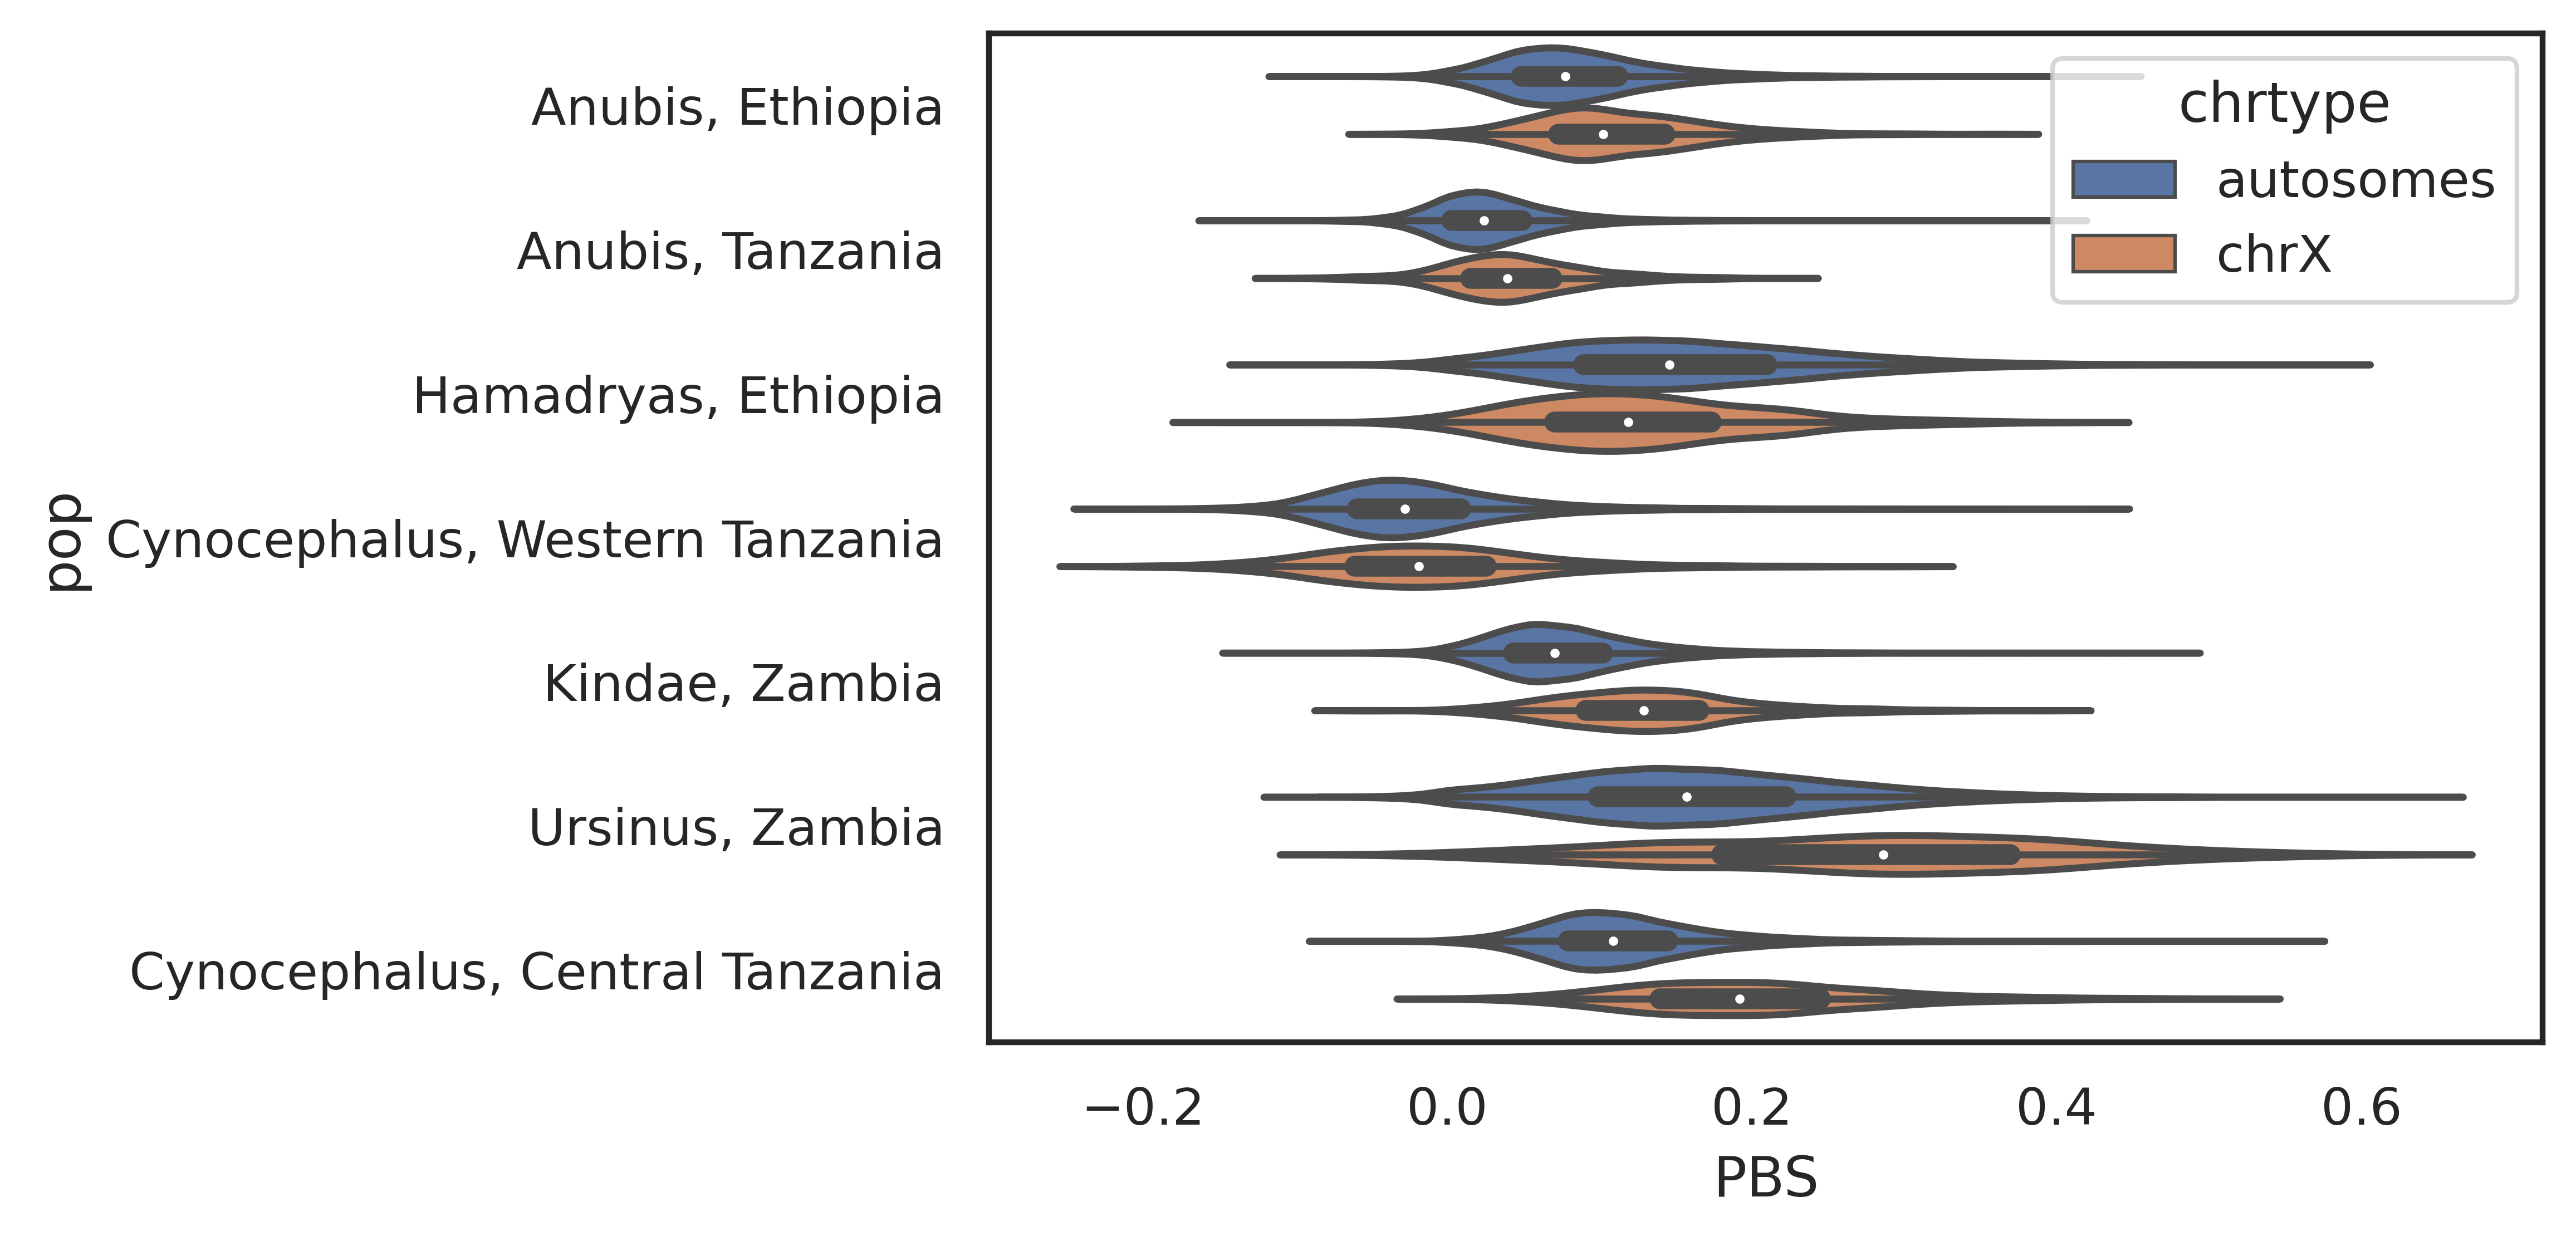

In [88]:
sns.violinplot(data=df_trios_p, x="PBS", y="pop", hue="chrtype")

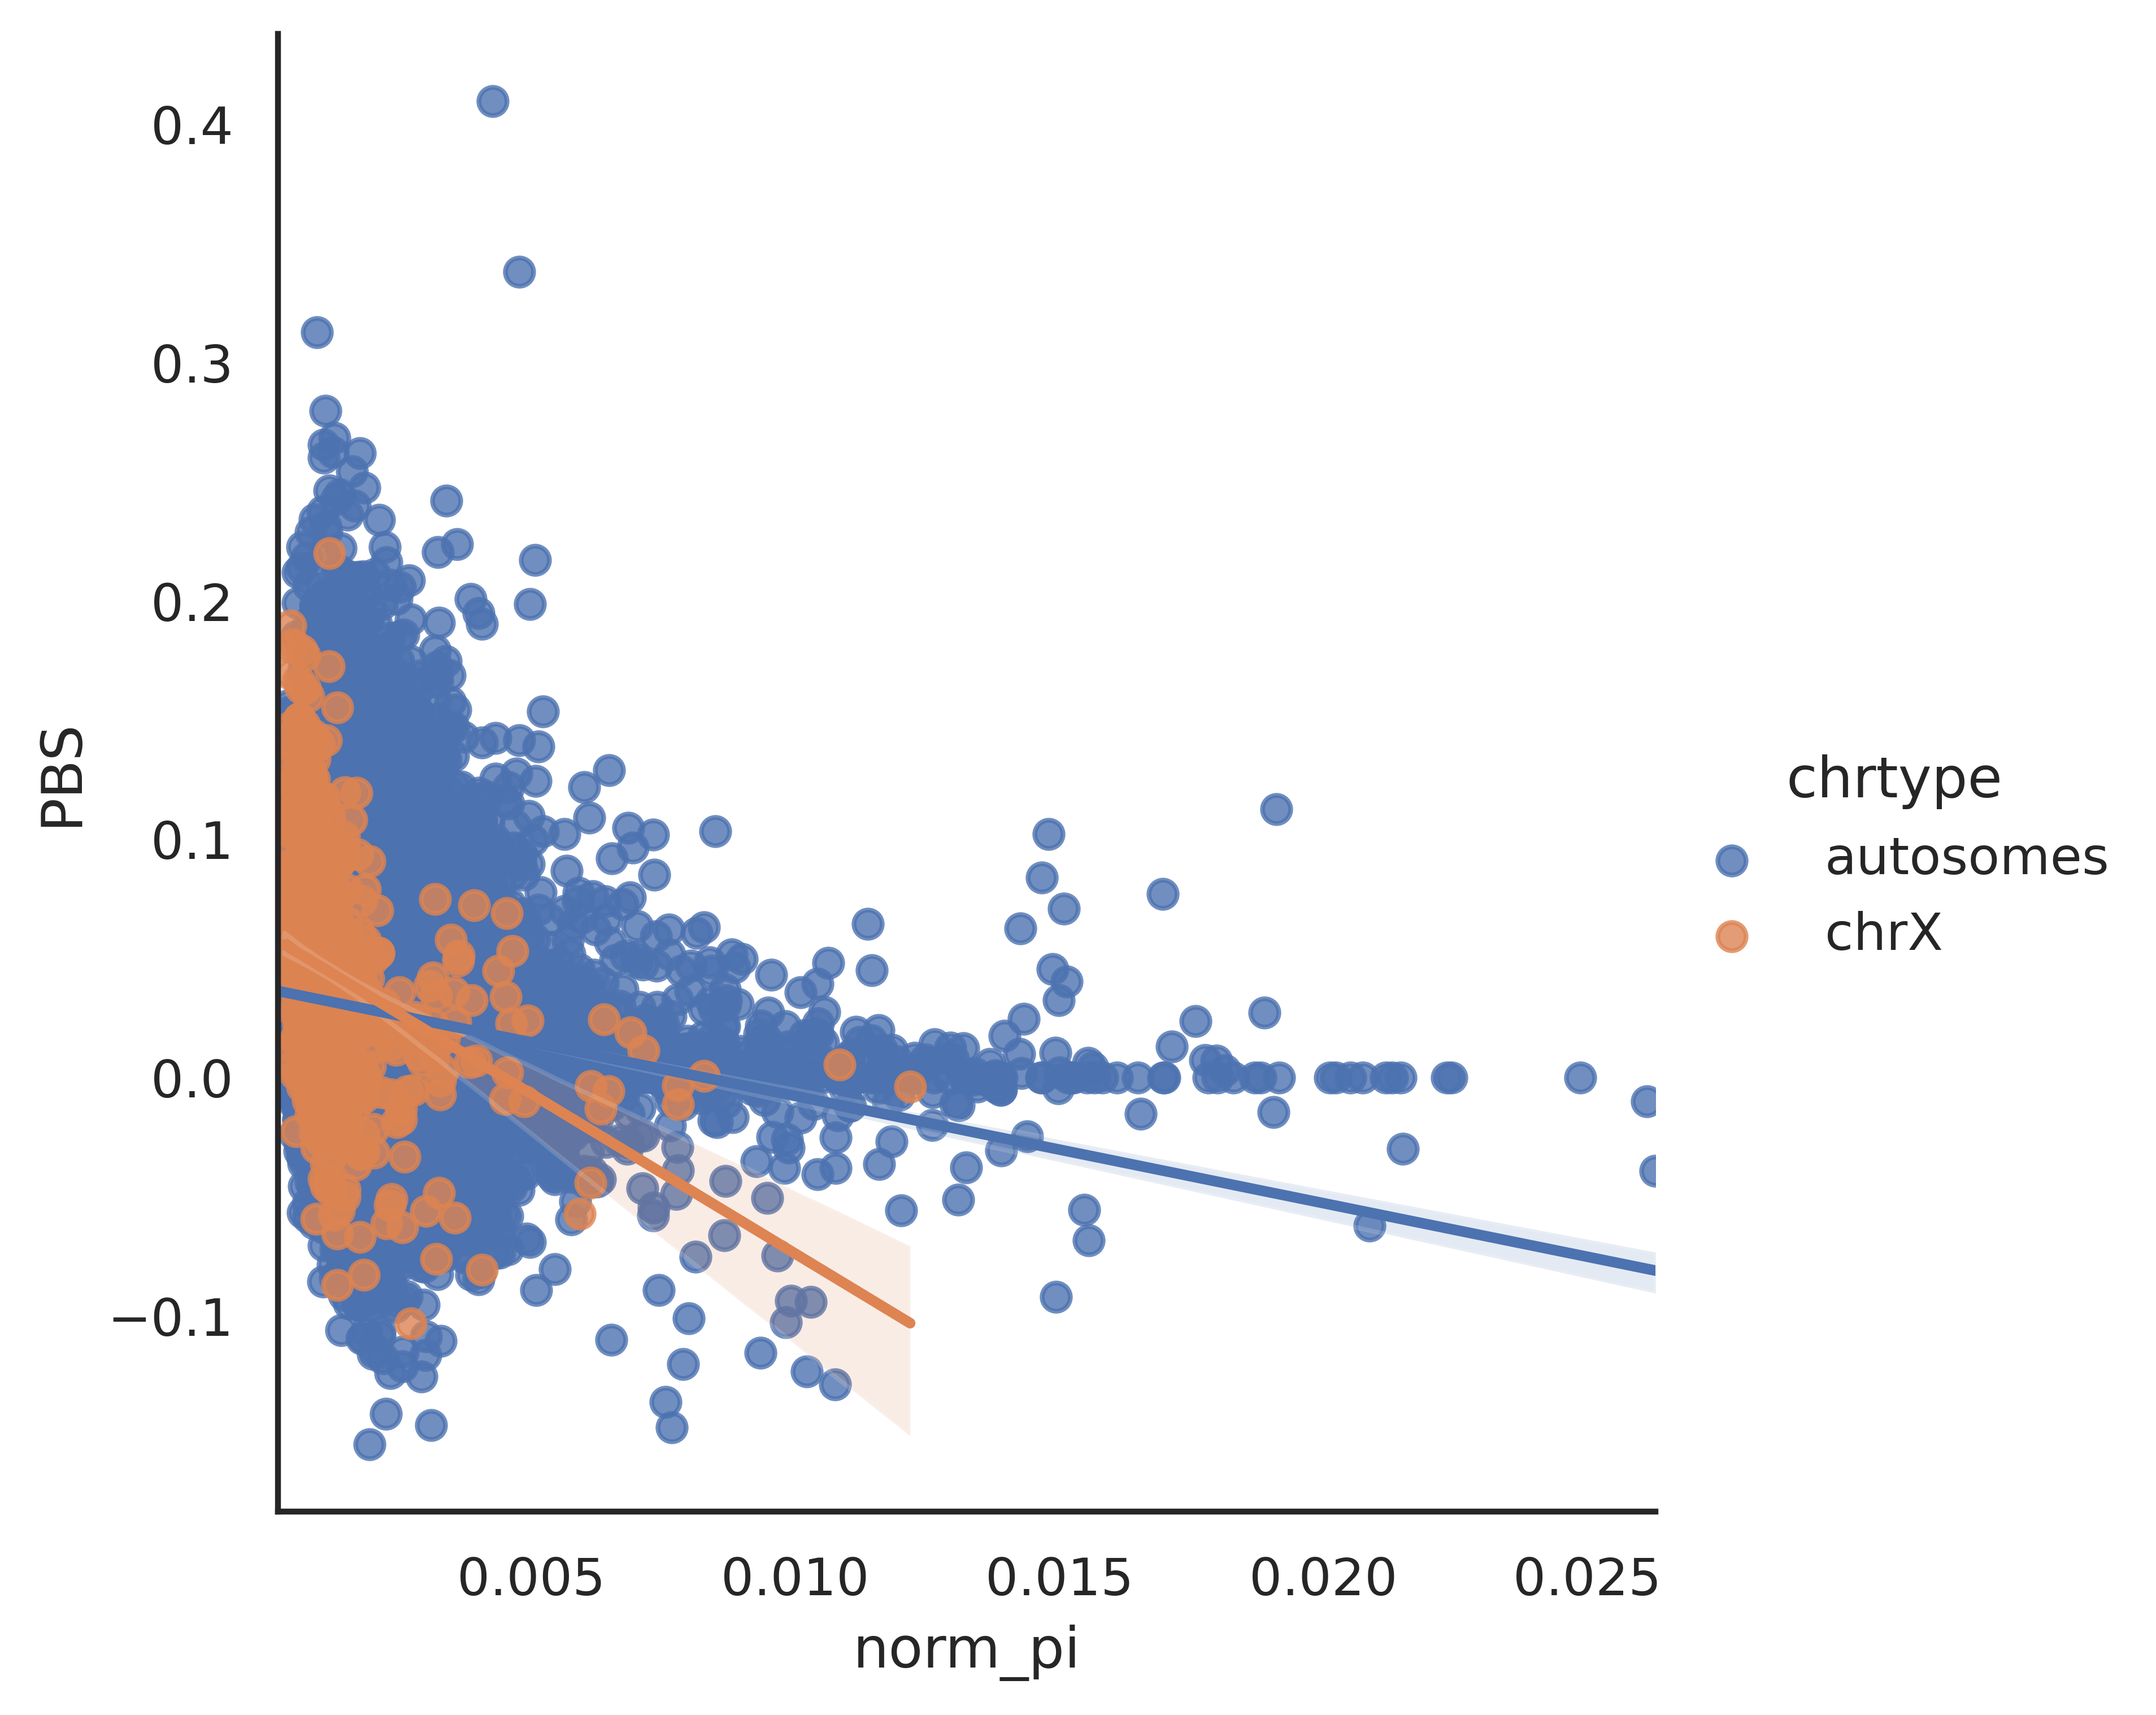

In [110]:
sns.lmplot(data=df_trios_p.loc[(df_trios_p["pop"] == "Anubis, Tanzania")], x="norm_pi", y="PBS", hue="chrtype")

<AxesSubplot:xlabel='window_size', ylabel='Count'>

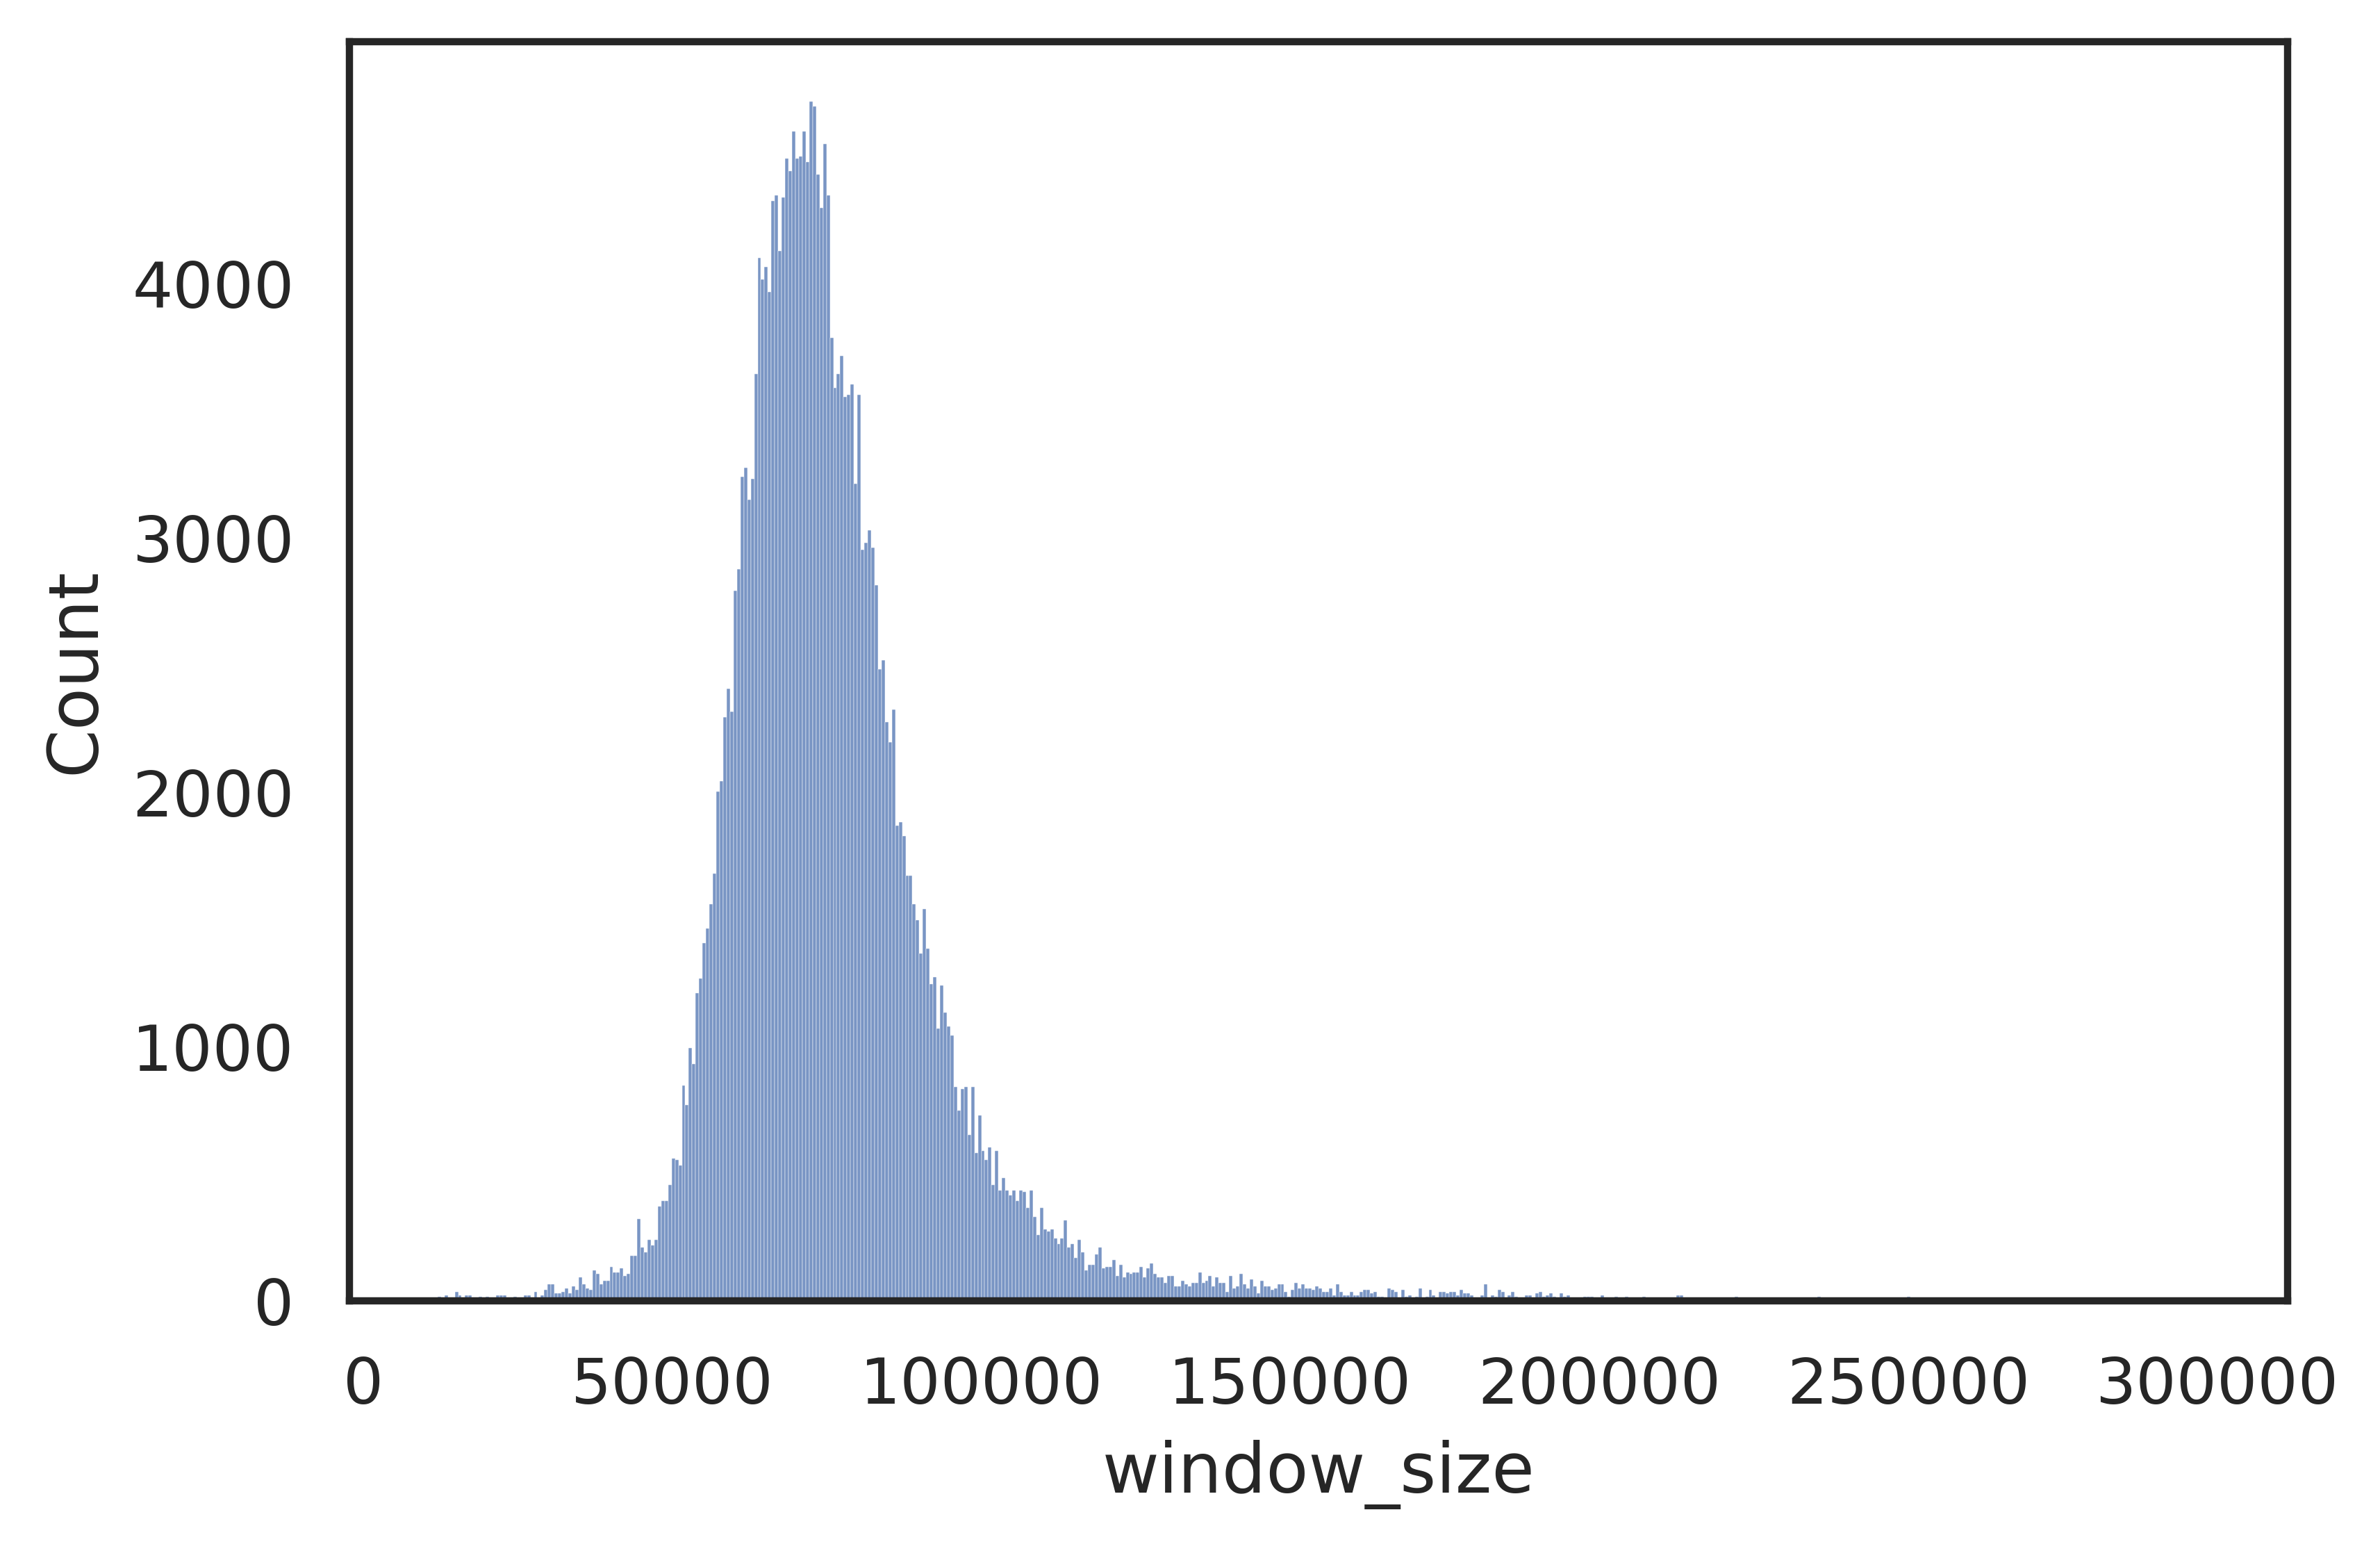

In [54]:
sns.histplot(data=df_trios.loc[df_trios.window_size < 300000], x="window_size")

In [70]:
df_trios.loc[df_trios.chrom=="chrX"].PBS.median(), df_trios.loc[df_trios.chrom!="chrX"].PBS.median()

(0.11769654135844475, 0.07668165320339285)

[(0.0, 0.6)]

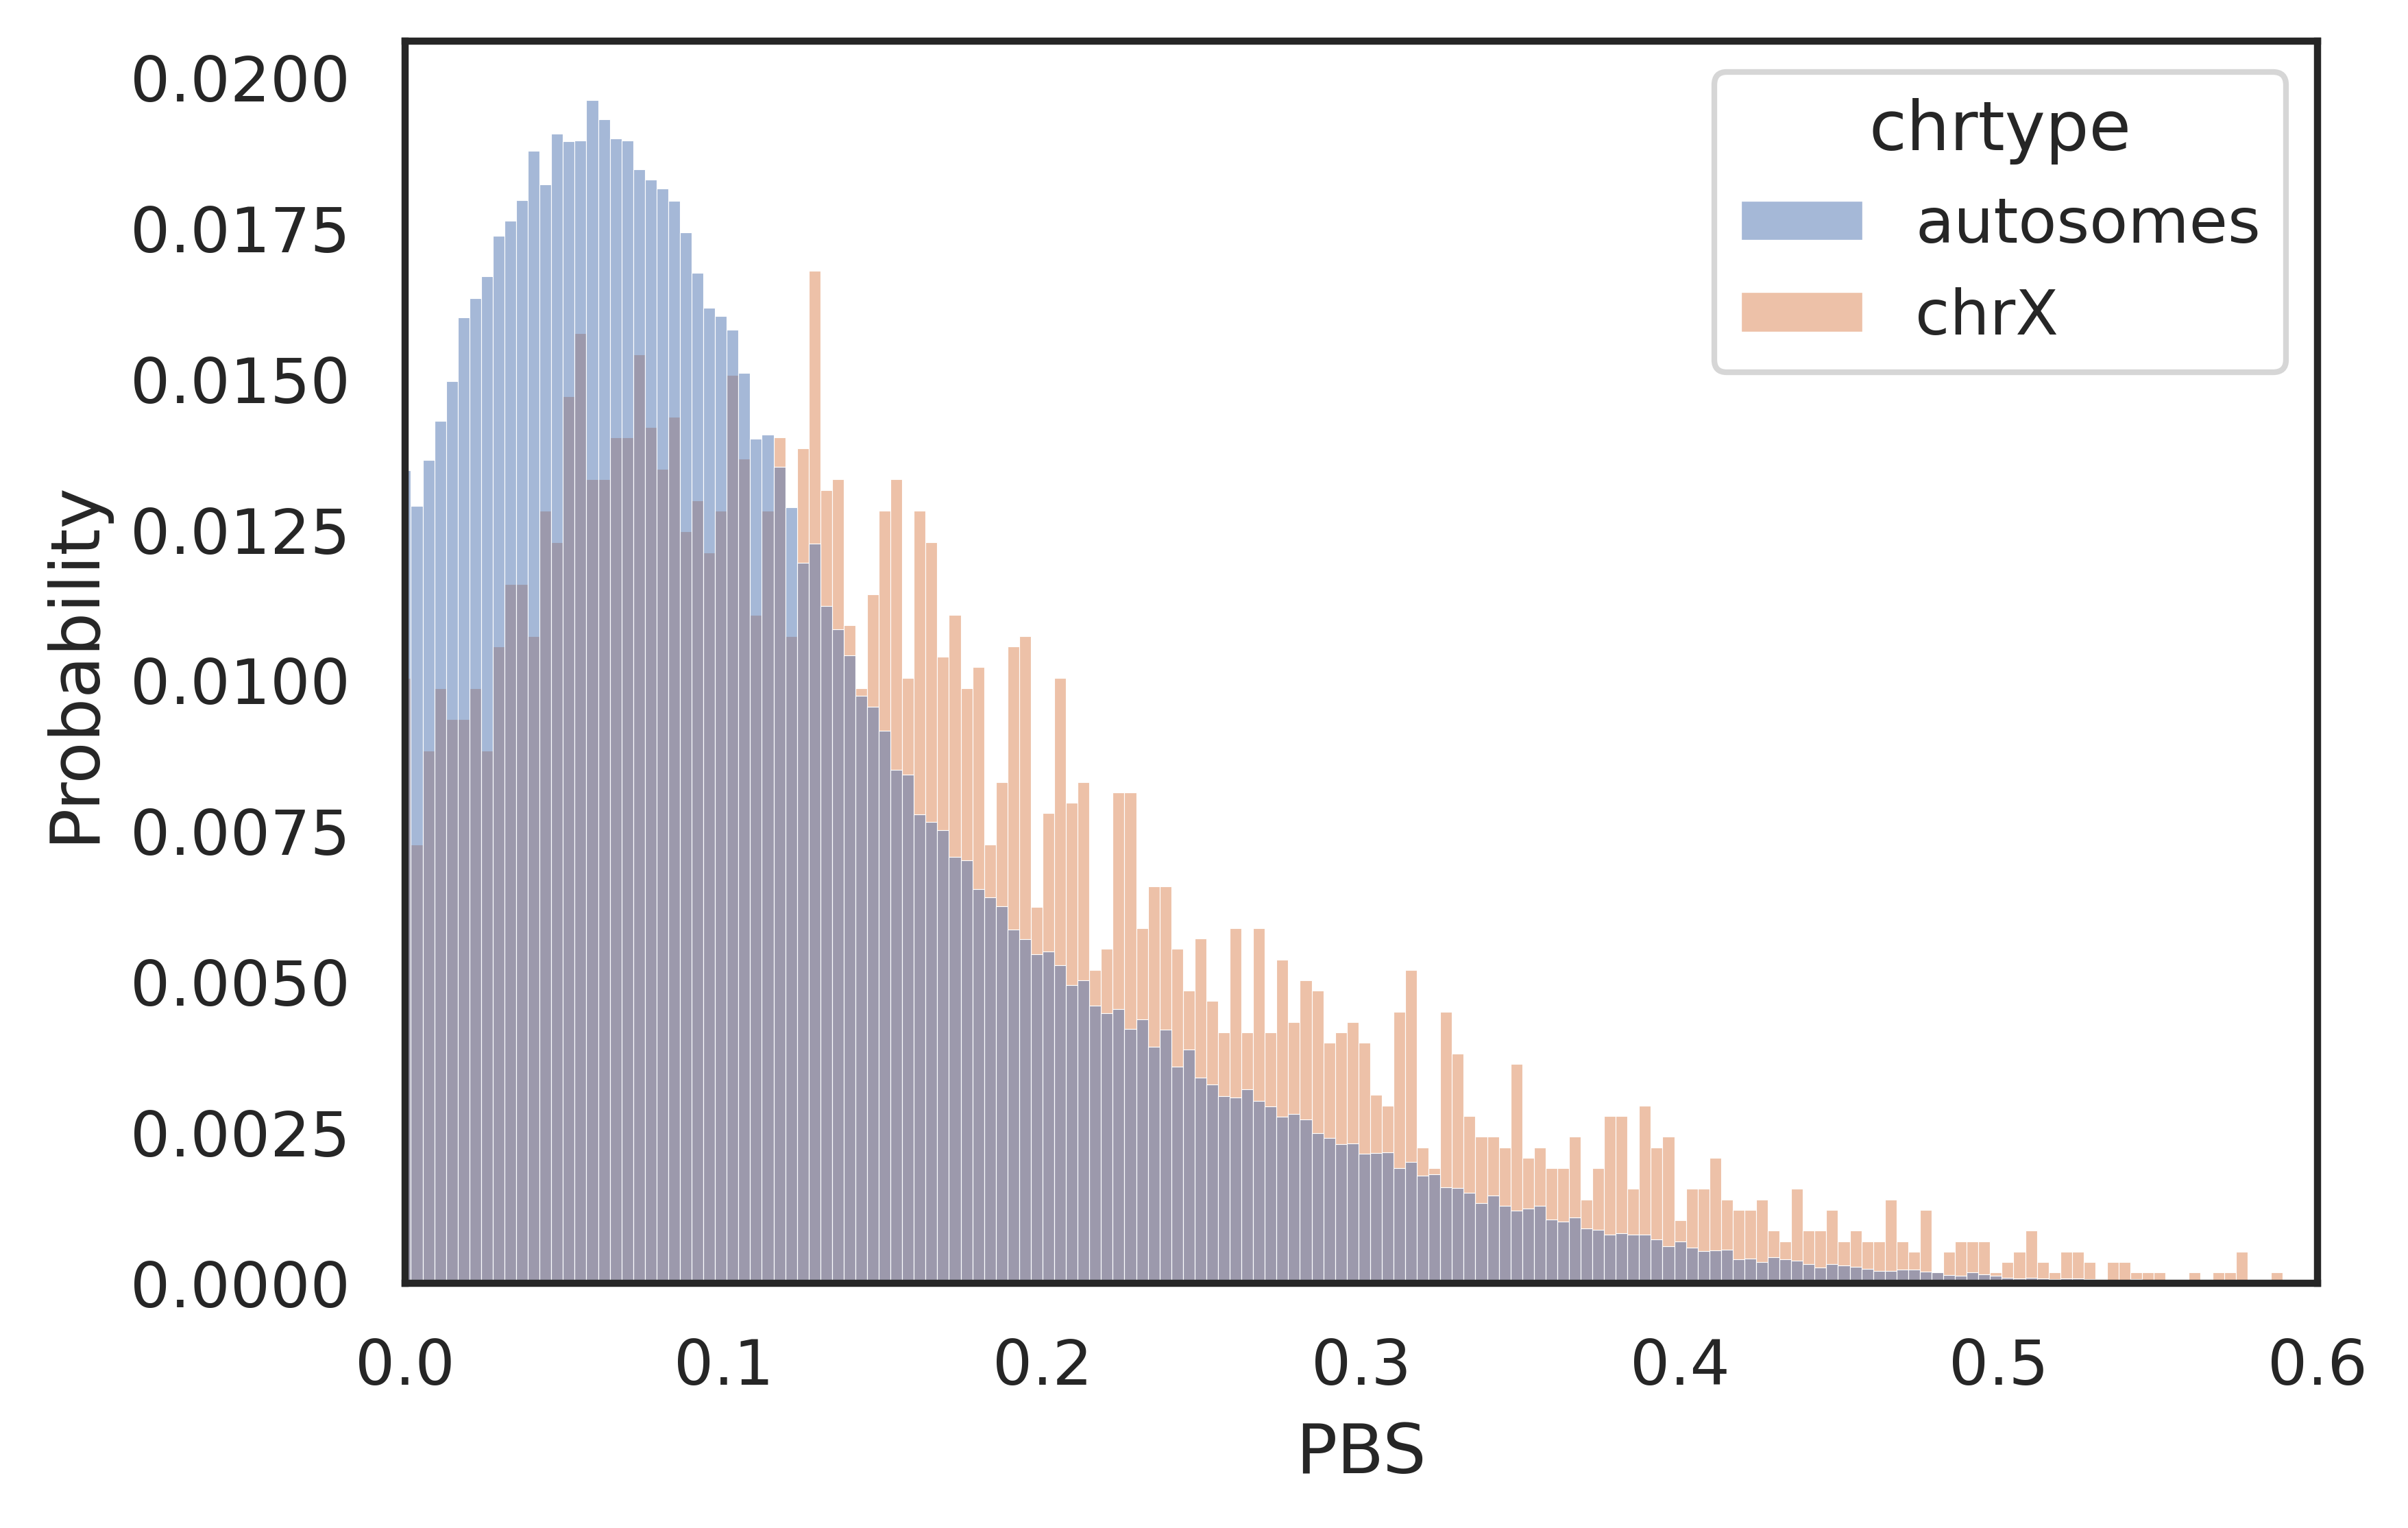

In [57]:
g = sns.histplot(data=df_trios_p, x="PBS", hue="chrtype", common_norm=False, stat="probability")
g.set(xlim=(0.0,0.6))

Text(0.5, 1.0, 'Cynocephalus, Central Tanzania')

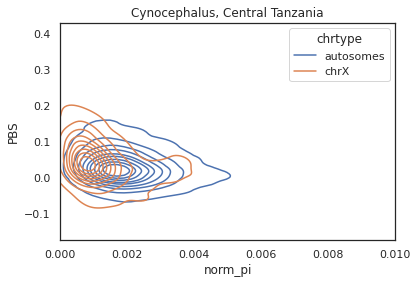

In [50]:
g = sns.kdeplot(data=df_trios.loc[df_trios["pop"] == 'Anubis, Tanzania'],
           x="norm_pi", y="PBS", hue="chrtype", common_norm=False)
g.set(xlim=(0, 0.01))
g.set_title("Cynocephalus, Central Tanzania")

In [33]:
anubis_subset = df_trios.loc[df_trios["pop"] == 'Anubis, Tanzania']

In [34]:
anubis_subset.loc[anubis_subset.chrom=="chrX"].PBS.median(), anubis_subset.loc[anubis_subset.chrom!="chrX"].PBS.median()

(0.039733999116814016, 0.023955322249829512)

In [37]:
anubis_subset.loc[anubis_subset.chrom=="chrX"].f_hat.median(), anubis_subset.loc[anubis_subset.chrom!="chrX"].f_hat.median()

(-0.013067306661812807, -0.013203891596611513)

[(-0.5, 0.5)]

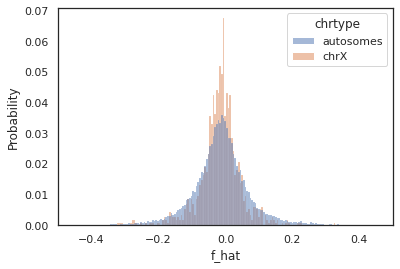

In [41]:
g = sns.histplot(data=anubis_subset, x="f_hat", hue="chrtype", common_norm=False, stat="probability")
g.set(xlim=(-0.5,0.5))

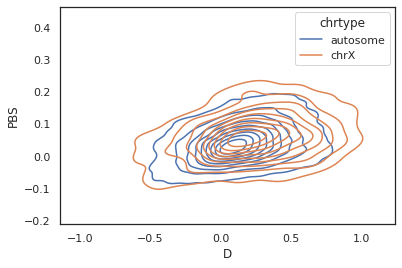

In [14]:
g = sns.kdeplot(data=anubis_subset,
           x="D", y="PBS", hue="chrtype", common_norm=False)
#g.set(xlim=(0, 0.1))

<AxesSubplot:xlabel='pi', ylabel='Count'>

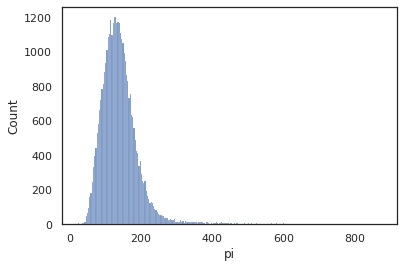

In [18]:
sns.histplot(data=anubis_subset, x="pi")

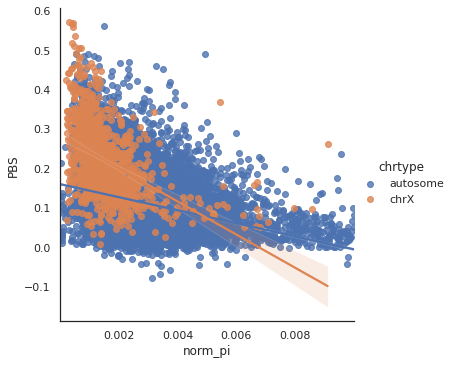

In [8]:
g = sns.lmplot(data=df_trios.loc[(df_trios["pop"] == 'Cynocephalus, Central Tanzania') & (df_trios.norm_pi < 0.01)],
           x="norm_pi", y="PBS", hue="chrtype")

Text(0.5, 1.0, 'Cynocephalus, Central Tanzania')

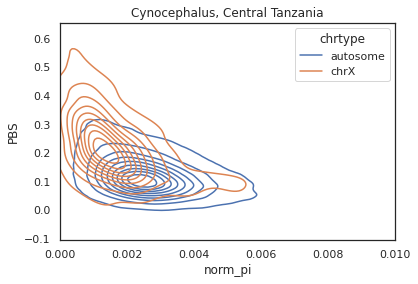

In [93]:
g = sns.kdeplot(data=df_trios.loc[df_trios["pop"] == 'Cynocephalus, Central Tanzania'],
           x="norm_pi", y="PBS", hue="chrtype", common_norm=False)
g.set(xlim=(0, 0.01))
g.set_title("Cynocephalus, Central Tanzania")

Text(0.5, 1.0, 'Kindae, Zambia')

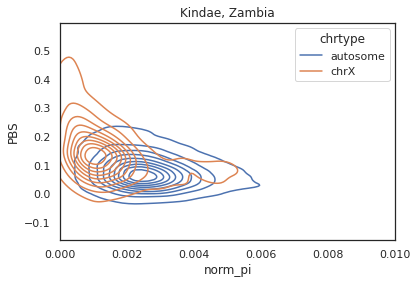

In [94]:
g = sns.kdeplot(data=df_trios.loc[df_trios["pop"] == 'Kindae, Zambia'],
           x="norm_pi", y="PBS", hue="chrtype", common_norm=False)
g.set(xlim=(0, 0.01))
g.set_title("Kindae, Zambia")

In [ ]:
sns.kdeplot(data=df_trios_p,
            x="pi", y="PBS", hue="chrtype", common_norm=False)

<AxesSubplot:xlabel='norm_pi', ylabel='PBS'>

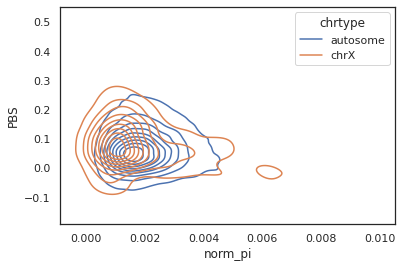

In [30]:
sns.kdeplot(data=df_trios_p.loc[(df_trios_p["pop"] == 'Anubis, Tanzania') & (df_trios_p.norm_pi < 0.01)],
            x="norm_pi", y="PBS", hue="chrtype", common_norm=False)

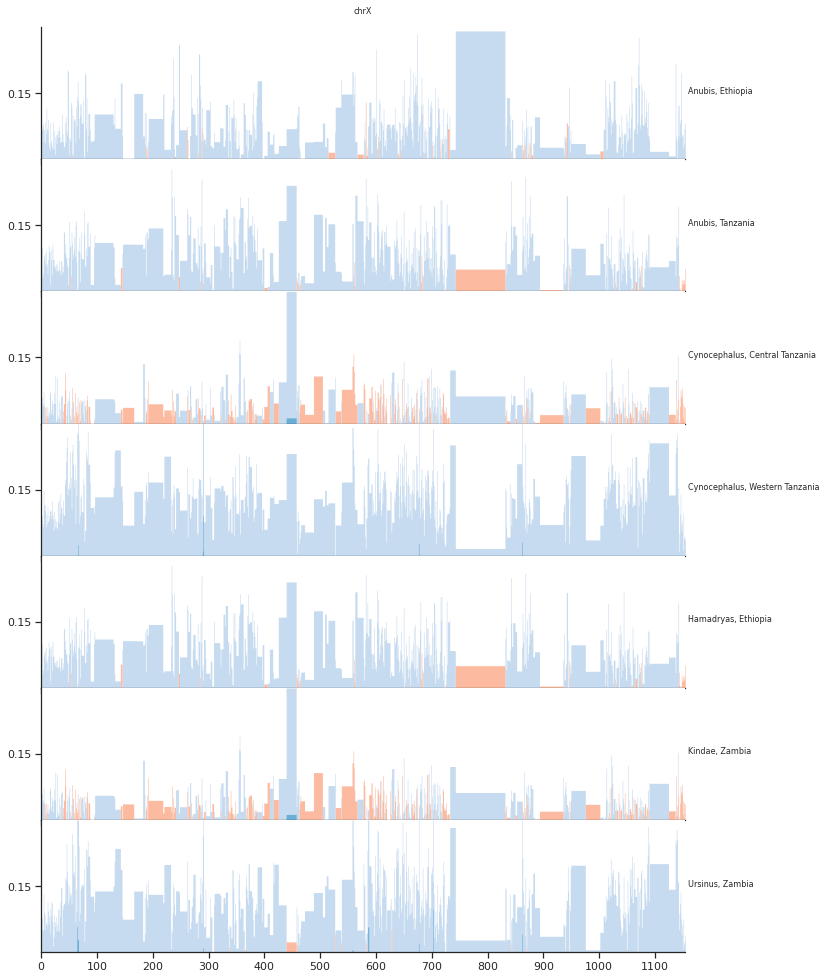

In [7]:
fig = horizonplot(df_trios_p.loc[df_trios_p.chrom=="chrX"], 'PBS', width=1, col='chrom', row='pop', aspect=5, size=2, cut=0.3)

In [64]:
df_trios_x = df_trios.loc[df_trios.chrom=="chrX"]
mean_pi = df_trios_x.pi.mean()
mean_window = df_trios_x.window_size.mean()
df_trios_x["PBS_pi"] = df_trios_x.PBS*(mean_pi/df_trios_x.pi)*(mean_window/df_trios_x.window_size)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


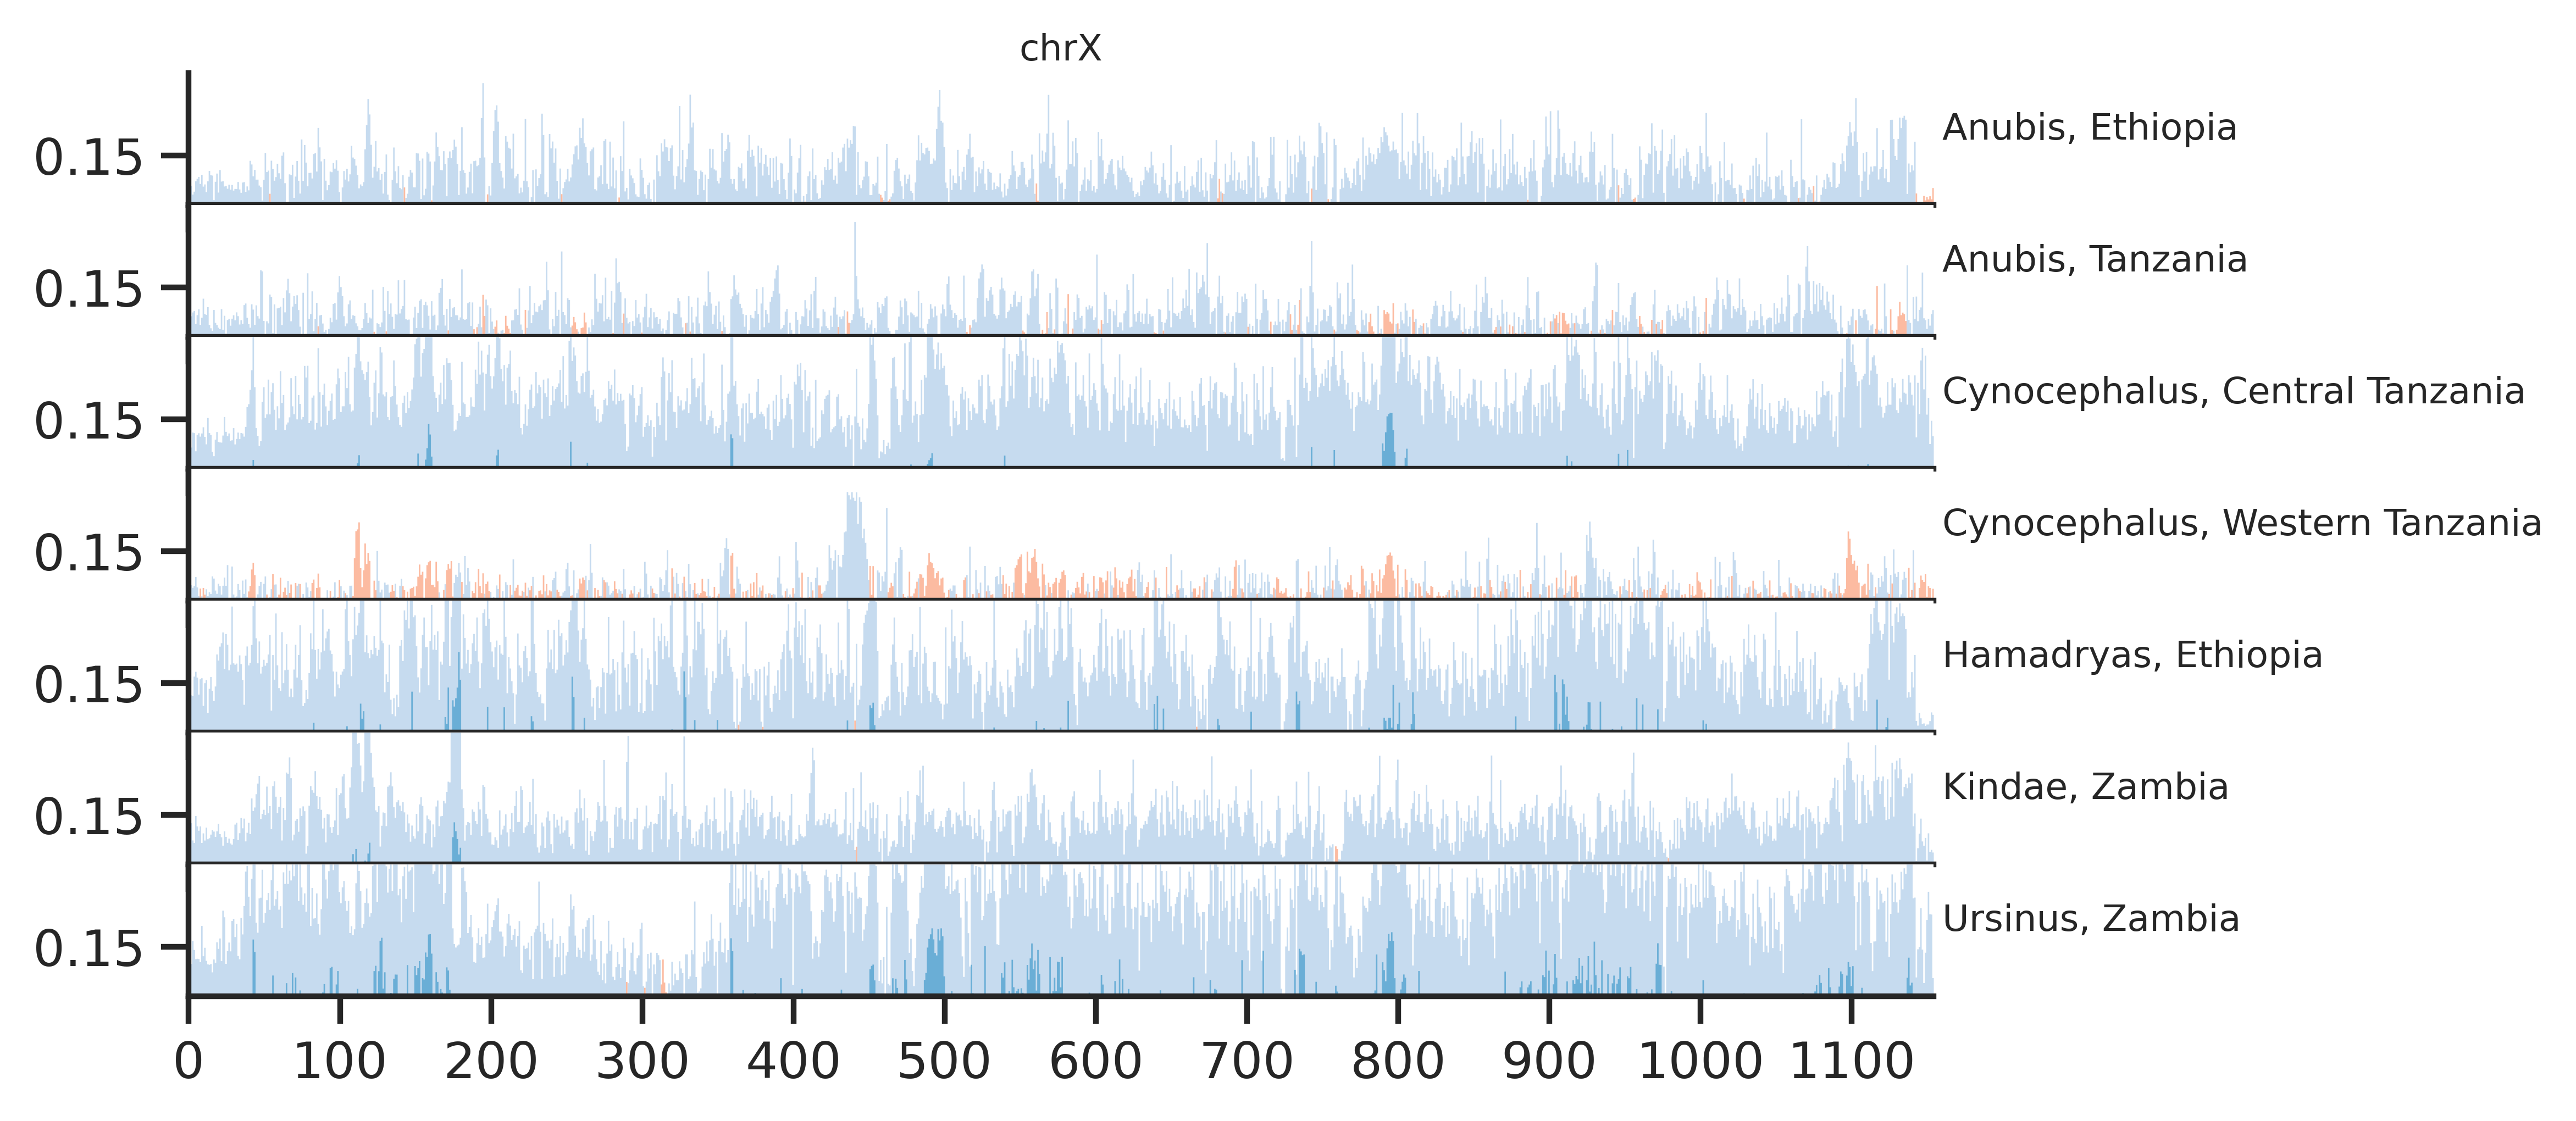

In [65]:
fig = horizonplot(df_trios_x, 'PBS', width=1, col='chrom', row='pop', aspect=12, size=0.5, cut=0.4)

In [49]:
fig = horizonplot(df_trios, 'PBS', width=1, col='chrom', row='pop', aspect=1, size=10, cut=0.4)

In [14]:
df_trios_x.loc[df_trios_x.start == 800]

start  start_pos    end_pos chrom         D     f_hat       fst  \
245856  800.0  103758485  103942106  chrX -0.182809 -0.019806  0.756516   
247010  800.0  103758485  103942106  chrX  0.182809  0.019980  0.721383   
248164  800.0  103758485  103942106  chrX  0.870193  0.598732  0.721383   
249318  800.0  103758485  103942106  chrX -0.454192 -0.075479  0.479348   
250472  800.0  103758485  103942106  chrX  0.454192  0.078314  0.586690   
251626  800.0  103758485  103942106  chrX  0.115433  0.050324  0.520171   
252780  800.0  103758485  103942106  chrX  0.817900  0.422701  0.586690   

             PBS          pi                             pop  window_size  \
245856  0.079523   79.026190                Anubis, Ethiopia       183621   
247010  0.025058  103.860041                Anubis, Tanzania       183621   
248164  0.491332   50.212482             Hamadryas, Ethiopia       183621   
249318  0.019841  154.000000  Cynocephalus, Western Tanzania       183621   
250472  0.139988  111.015196                  Kindae, Zambia       183621   
251626  0.377321   33.400000                 Ursinus, Zambia       183621   
252780  0.319794  121.297079  Cynocephalus, Central Tanzania       183621   

       chrtype   norm_pi    PBS_pi  
245856    chrX  0.000430  0.097565  
247010    chrX  0.000566  0.023392  
248164    chrX  0.000273  0.948709  
249318    chrX  0.000839  0.012492  
250472    chrX  0.000605  0.122258  
251626    chrX  0.000182  1.095302  
252780    chrX  0.000661  0.255617

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


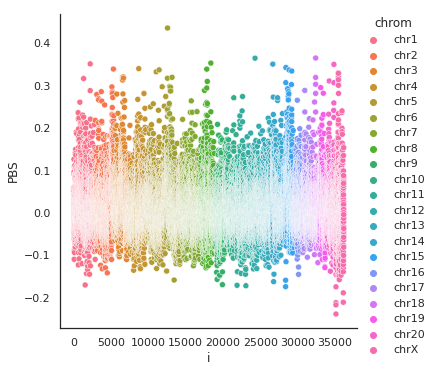

In [26]:
single_species = df_trios.loc[df_trios["pop"] == "Cynocephalus, Western Tanzania"]
single_species.reset_index(inplace=True, drop=True); single_species['i'] = single_species.index
sns.relplot(data=single_species, x="i", y="PBS", hue="chrom")

In [24]:
df_trios.loc[df_trios.PBS < -0.177]

start  start_pos    end_pos  chrom         D     f_hat       fst  \
166038   782.0   58758918   58871736  chr12 -0.768146 -0.220919  0.499998   
248628   110.0   10431765   10615607   chrX -0.915906 -0.340203  0.282126   
248629   111.0   10615607   10815865   chrX -0.901166 -0.219680  0.370361   
248630   112.0   10815865   11014050   chrX -0.853888 -0.225663  0.379339   
249615  1097.0  144103020  144291918   chrX -0.970619 -0.292151  0.370504   
249616  1098.0  144291918  144483404   chrX -0.950907 -0.262218  0.356923   

             PBS          pi                             pop  window_size  \
166038 -0.177899  166.438984                Anubis, Tanzania       112818   
248628 -0.211268  243.200000  Cynocephalus, Western Tanzania       183842   
248629 -0.216647  212.666667  Cynocephalus, Western Tanzania       200258   
248630 -0.238032  298.166667  Cynocephalus, Western Tanzania       198185   
249615 -0.210332  339.800000  Cynocephalus, Western Tanzania       188898   
249616 -0.188252  289.733333  Cynocephalus, Western Tanzania       191486   

         chrtype   norm_pi  
166038  autosome  0.001475  
248628      chrX  0.001323  
248629      chrX  0.001062  
248630      chrX  0.001504  
249615      chrX  0.001799  
249616      chrX  0.001513

In [111]:
#Investigating negative PBS
zarr_dir = "/faststorage/project/baboondiversity/data/PG_baboons_mmul_20_04_2021/callset.zarr/chr{}"
callset = zarr.open_group(zarr_dir.format("12"), mode="r")
gt = allel.GenotypeArray(callset["calldata/GT"])
bi_sites = gt.count_alleles().is_biallelic()
pos = callset["variants/POS"][:].compress(bi_sites)
pos_sorted = allel.SortedIndex(pos)
gt = gt.compress(bi_sites)

In [112]:
pos_range = locate_range_empty_allowed(pos_sorted, 58758918, 58871736)

In [113]:
gt_region = allel.GenotypeArray(gt[pos_range])
a_ac = gt_region.take(meta_data_samples.loc[(meta_data_samples.C_origin == 'Anubis, Ethiopia') &
                                    (meta_data_samples.Sex == "F")].callset_index.values, axis=1).count_alleles(max_allele=1)
b_ac = gt_region.take(meta_data_samples.loc[(meta_data_samples.C_origin == 'Anubis, Tanzania') &
                                    (meta_data_samples.Sex == "F")].callset_index.values, axis=1).count_alleles(max_allele=1)
c_ac = gt_region.take(meta_data_samples.loc[(meta_data_samples.C_origin == 'Hamadryas, Ethiopia') &
                                    (meta_data_samples.Sex == "F")].callset_index.values, axis=1).count_alleles(max_allele=1)

In [47]:
pbs_est = allel.pbs(b_ac, a_ac, c_ac, 2500)
fst_est1 = allel.moving_hudson_fst(b_ac, c_ac, 2500)
fst_est2 = allel.moving_hudson_fst(a_ac, c_ac, 2500)
fst_est3 = allel.moving_hudson_fst(a_ac, b_ac, 2500)
fst_est1, fst_est2, fst_est3

(array([0.49999844]), array([0.86640344]), array([0.33614885]))

In [71]:
b_ac[(b_ac[:,0]== 0) & (b_ac[:,1]== 0)]

<AlleleCountsArray shape=(9, 2) dtype=int32>
0 0
0 0
0 0
...
0 0
0 0
0 0

In [53]:
fst_est1+fst_est3

array([0.83614729])

In [48]:
fst_est1+fst_est3

array([0.83614729])

In [46]:
t12 = -np.log(1 - fst_est1)
t13 = -np.log(1 - fst_est3)
t23 = -np.log(1 - fst_est2)
ret = (t12 + t13 - t23) / 2
norm = 1 + (t12 + t13 + t23) / 2
ret = ret / norm
ret, t12, t13, t23

(array([-0.17789873]),
 array([0.69314407]),
 array([0.40969732]),
 array([2.01293077]))

Defining inputs. Here, size refers to number of sites

In [4]:
#Case1: Flow from hamadryas to anubis in ethiopia
a_name, b_name, c_name, d_name = "Anubis, Tanzania", "Anubis, Ethiopia", "Hamadryas, Ethiopia", "Gelada, Captive"
chromosome_numbers = ['{}'.format(x) for x in range(1, 21)] + ['X']
size = 1000

In [5]:
df_list = []
for chrom_number in ["7", "X"]:
    a_ac, b_ac, c_ac, d_ac, b_gt, pos = generate_input(a_name, b_name, c_name, d_name, chrom_number)
    window_df = windowed_stats_chrom(a_ac, b_ac, c_ac, d_ac, pos, size)
    window_df["pop"] = b_name
    ld_df = windowed_ld(b_gt, size)
    chrom_df = pd.concat([window_df, ld_df], axis=1)
    chrom_df.insert(loc=2, column="chrom", value="chr"+chrom_number)
    df_list.append(chrom_df)
    print(chrom_number)
aah_df = pd.concat(df_list)

7
X


In [6]:
aah_df

start_pos    end_pos chrom         D     f_hat        pi       fst  \
0           890     192478  chr7 -0.095443 -0.072140  0.000437  0.068312   
1        192478     335143  chr7  0.005785  0.004870  0.001255  0.028320   
2        335143     371929  chr7 -0.173571 -0.051685  0.001111  0.302649   
3        371929     426349  chr7 -0.159718 -0.080500  0.000848  0.299745   
4        426349     465364  chr7 -0.249311 -0.113623  0.001399  0.231774   
...         ...        ...   ...       ...       ...       ...       ...   
2882  153217879  153239216  chrX -0.002783 -0.002153  0.008353  0.001527   
2883  153239216  153252264  chrX -0.033458 -0.026269  0.020091 -0.000442   
2884  153252264  153286683  chrX -0.067899 -0.056660  0.002844  0.026447   
2885  153286683  153305261  chrX -0.202102 -0.171444  0.003275  0.078225   
2886  153305261  153368156  chrX -0.233504 -0.149847  0.000327  0.226691   

      start  window_size               pop        LD  LD_counts  
0         0       191588  Anubis, Ethiopia  0.206349        188  
1         1       142665  Anubis, Ethiopia  0.070295        165  
2         2        36786  Anubis, Ethiopia  0.266103        146  
3         3        54420  Anubis, Ethiopia  0.161973        169  
4         4        39015  Anubis, Ethiopia  0.149002        165  
...     ...          ...               ...       ...        ...  
2882   2882        21337  Anubis, Ethiopia  0.600000        438  
2883   2883        13048  Anubis, Ethiopia  0.746032        628  
2884   2884        34419  Anubis, Ethiopia  0.070899        130  
2885   2885        18578  Anubis, Ethiopia  0.059713         96  
2886   2886        62895  Anubis, Ethiopia  0.059713         60  

[8375 rows x 12 columns]

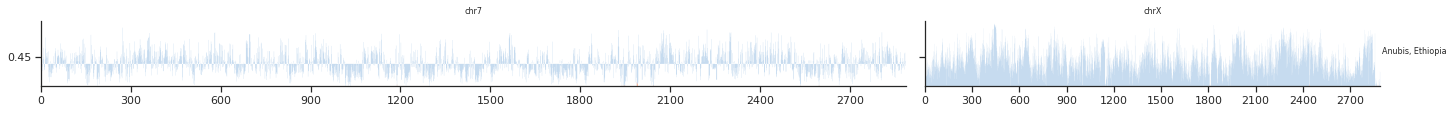

In [38]:
fig = horizonplot(aah_df, 'fst', width=1, col='chrom', row='pop', aspect=5, size=2, cut=1)

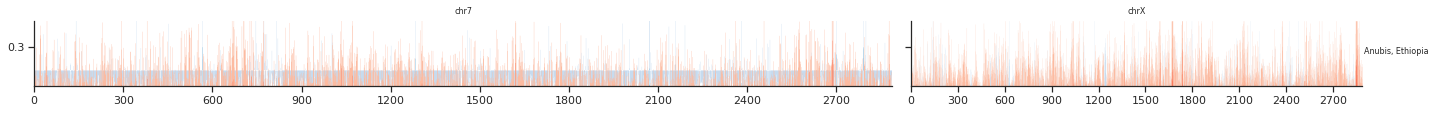

In [37]:
fig = horizonplot(aah_df, 'f_hat', width=1, col='chrom', row='pop', aspect=5, size=2)

In [10]:
print(aah_df.loc[aah_df.chrom=="chr7"].fst.mean(), aah_df.loc[aah_df.chrom=="chrX"].fst.mean())

0.36275782161697145 0.40755882013529793


In [11]:
print(aah_df.loc[aah_df.chrom=="chr7"].f_hat.mean(), aah_df.loc[aah_df.chrom=="chrX"].f_hat.mean())

-0.05719466734329264 -0.092227001528054


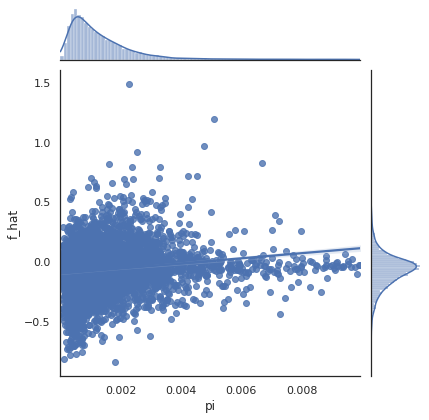

In [12]:
sns.jointplot(data=aah_df.loc[aah_df.pi < 0.01], x="pi", y="f_hat", kind="reg")

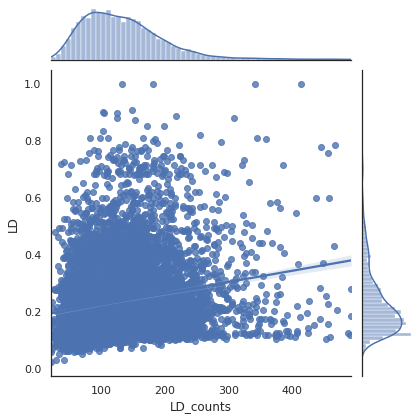

In [13]:
sns.jointplot(data=aah_df.loc[(aah_df.LD_counts > 20) & (aah_df.LD_counts < 500)],
           x="LD_counts", y="LD", kind="reg")

In [48]:
aah_subset = aah_df.loc[(aah_df.LD_counts > 100) & (aah_df.LD_counts < 500) & (aah_df.window_size < 50000) & (aah_df.window_size > 20000)]

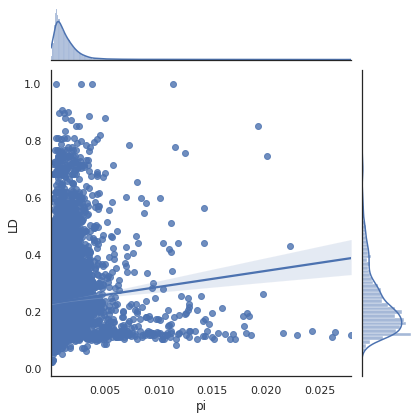

In [14]:
sns.jointplot(data=aah_df,
           x="pi", y="LD", kind="reg")

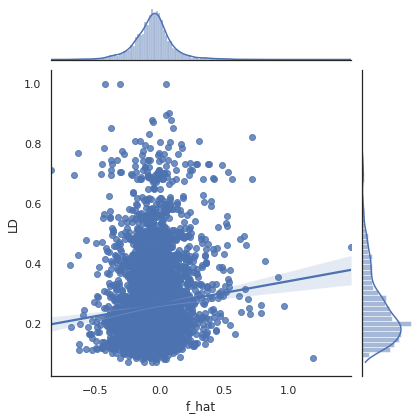

In [50]:
sns.jointplot(data=aah_subset, x="f_hat", y="LD", kind="reg")

In [15]:
#Checking correlation
aah_subset = aah_df.loc[aah_df.chrom=="chrX"]
results = sm.OLS(aah_subset.LD_counts, aah_subset.LD).fit()
#print(results.summary())
print(scipy.stats.pearsonr(aah_subset.f_hat, aah_subset.LD))
print(scipy.stats.pearsonr(aah_subset.f_hat, aah_subset.LD_counts))
print(scipy.stats.pearsonr(aah_subset.LD_counts, aah_subset.LD))
print(scipy.stats.pearsonr(aah_subset.LD_counts, aah_subset.window_size))

(0.10660066756932353, 9.377163188218345e-09)
(0.17164838477407315, 1.5747423028294036e-20)
(0.19342332817312127, 9.862619456981108e-26)
(-0.29808245498558783, 2.524639390078935e-60)


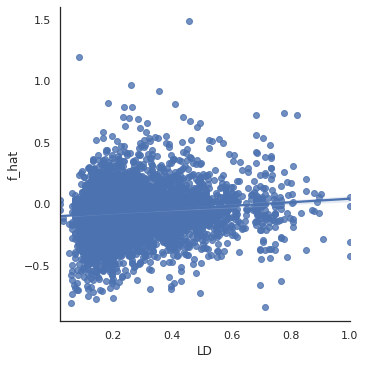

In [16]:
sns.lmplot(data=aah_df, x="LD", y="f_hat")

<AxesSubplot:xlabel='f_hat', ylabel='Count'>

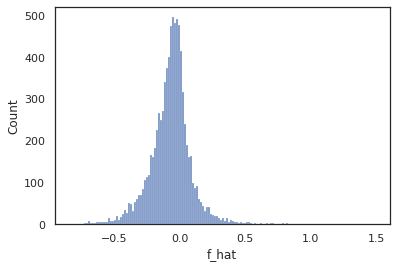

In [17]:
sns.histplot(data=aah_df, x="f_hat")

<AxesSubplot:xlabel='LD', ylabel='Count'>

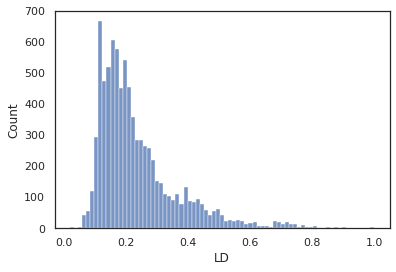

In [18]:
sns.histplot(data=aah_df, x="LD")

<AxesSubplot:xlabel='LD', ylabel='f_hat'>

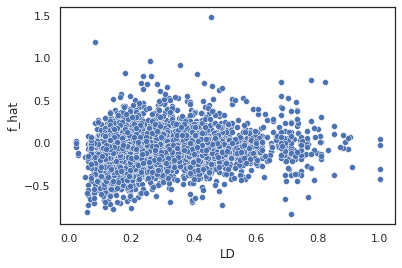

In [19]:
sns.scatterplot(data=aah_df, x="LD", y="f_hat")

In [20]:
#Case2, gene flow from cynocephalus in central tanzania to anubis
a_name, b_name, c_name, d_name = "Anubis, Ethiopia", "Anubis, Tanzania", "Cynocephalus, Central Tanzania", "Gelada, Captive"
chromosome_numbers = ['{}'.format(x) for x in range(1, 21)] + ['X']
size = 1000

In [21]:
df_list = []
for chrom_number in ["7", "X"]:
    a_ac, b_ac, c_ac, d_ac, b_gt, pos = generate_input(a_name, b_name, c_name, d_name, chrom_number)
    window_df = windowed_stats_chrom(a_ac, b_ac, c_ac, d_ac, pos, size)
    window_df["pop"] = b_name
    ld_df = windowed_ld(b_gt, size)
    chrom_df = pd.concat([window_df, ld_df], axis=1)
    chrom_df.insert(loc=2, column="chrom", value="chr"+chrom_number)
    df_list.append(chrom_df)
    print(chrom_number)
aac_df = pd.concat(df_list)

7
X


In [22]:
aac_df

start_pos    end_pos chrom         D     f_hat        pi       fst  \
0           890     192478  chr7 -0.054337 -0.038431  0.000649  0.150568   
1        192478     335143  chr7 -0.044649 -0.036313  0.001275  0.079915   
2        335143     371929  chr7 -0.176467 -0.070399  0.001537  0.180088   
3        371929     426349  chr7 -0.059918 -0.026092  0.001218  0.237365   
4        426349     465364  chr7 -0.080912 -0.031715  0.001596  0.272611   
...         ...        ...   ...       ...       ...       ...       ...   
2882  153217879  153239216  chrX -0.197703 -0.128243  0.006171  0.230259   
2883  153239216  153252264  chrX -0.123666 -0.103965  0.014592  0.080239   
2884  153252264  153286683  chrX -0.012304 -0.006955  0.003114  0.277153   
2885  153286683  153305261  chrX -0.051442 -0.022355  0.004500  0.394044   
2886  153305261  153368156  chrX -0.151316 -0.025721  0.000653  0.496405   

      start  window_size               pop        LD  LD_counts  
0         0       191588  Anubis, Tanzania  0.023119        458  
1         1       142665  Anubis, Tanzania  0.013538        319  
2         2        36786  Anubis, Tanzania  0.027935        309  
3         3        54420  Anubis, Tanzania  0.027179        344  
4         4        39015  Anubis, Tanzania  0.029595        303  
...     ...          ...               ...       ...        ...  
2882   2882        21337  Anubis, Tanzania  0.250796        588  
2883   2883        13048  Anubis, Tanzania  0.399065        723  
2884   2884        34419  Anubis, Tanzania  0.014023        321  
2885   2885        18578  Anubis, Tanzania  0.018284        348  
2886   2886        62895  Anubis, Tanzania  0.013432        227  

[8375 rows x 12 columns]

In [23]:
aac_df.groupby(["chrom"]).mean()

start_pos       end_pos         D     f_hat        pi       fst  \
chrom                                                                       
chr7   8.567322e+07  8.570418e+07 -0.073677 -0.013444  0.002120  0.330289   
chrX   7.455251e+07  7.460563e+07 -0.148986 -0.020684  0.001135  0.467121   

        start   window_size        LD   LD_counts  
chrom                                              
chr7   2743.5  30952.563229  0.048597  306.594934  
chrX   1443.0  53123.690336  0.081990  262.258400

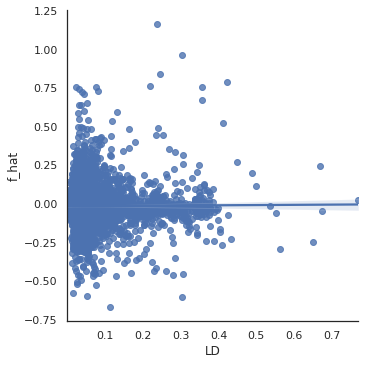

In [24]:
sns.lmplot(data=aac_df, x="LD", y="f_hat")

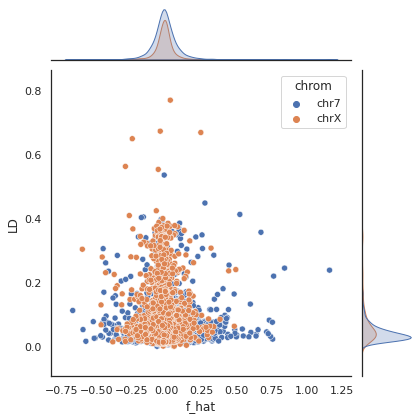

In [25]:
sns.jointplot(data=aac_df.loc[(aac_df.LD_counts > 20) & (aac_df.LD_counts < 500)],
           x="f_hat", y="LD", hue="chrom")

In [26]:
aac_subset = aac_df.loc[aac_df.chrom=="chrX"]
print(scipy.stats.pearsonr(aac_subset.f_hat, aac_subset.LD))
print(scipy.stats.pearsonr(aac_subset.f_hat, aac_subset.LD_counts))
print(scipy.stats.pearsonr(aac_subset.LD_counts, aac_subset.LD))
print(scipy.stats.pearsonr(aac_subset.window_size, aac_subset.LD))

(-0.06446853092080645, 0.0005281607440708549)
(-0.10394053419798727, 2.1739285139855286e-08)
(0.021794014141614897, 0.24174272545262274)
(-0.08040234059762404, 1.5238273504740908e-05)


In [27]:
#Case3, gene flow from anubis in tanzania to "cynocephalus"
a_name, b_name, c_name, d_name = "Kindae, Zambia", "Cynocephalus, Western Tanzania", "Anubis, Tanzania", "Gelada, Captive"
chromosome_numbers = ['{}'.format(x) for x in range(1, 21)] + ['X']
size = 1000

In [28]:
df_list = []
for chrom_number in ["7", "X"]:
    a_ac, b_ac, c_ac, d_ac, b_gt, pos = generate_input(a_name, b_name, c_name, d_name, chrom_number)
    window_df = windowed_stats_chrom(a_ac, b_ac, c_ac, d_ac, pos, size)
    window_df["pop"] = b_name
    ld_df = windowed_ld(b_gt, size)
    chrom_df = pd.concat([window_df, ld_df], axis=1)
    chrom_df.insert(loc=2, column="chrom", value="chr"+chrom_number)
    df_list.append(chrom_df)
    print(chrom_number)
kca_df = pd.concat(df_list)

7
X


In [29]:
print(kca_df.loc[kca_df.chrom=="chr7"].fst.mean(), kca_df.loc[kca_df.chrom=="chrX"].fst.mean())

0.1929531826314208 0.3805920039152173


In [30]:
print(kca_df.loc[kca_df.chrom=="chr7"].f_hat.mean(), kca_df.loc[kca_df.chrom=="chrX"].f_hat.mean())

-0.11580179414147344 -0.057624778465769175


In [31]:
print(kca_df.loc[kca_df.chrom=="chr7"].pi.mean(), kca_df.loc[kca_df.chrom=="chrX"].pi.mean())

0.003125500945164436 0.0017876574503629952


In [33]:
kca_df

start_pos    end_pos chrom         D     f_hat        pi       fst  \
0           890     192478  chr7 -0.050247 -0.038035  0.000656  0.072314   
1        192478     335143  chr7 -0.074080 -0.061828  0.001510  0.019114   
2        335143     371929  chr7 -0.300781 -0.085669  0.001345  0.261887   
3        371929     426349  chr7 -0.030722 -0.015022  0.001336  0.164514   
4        426349     465364  chr7 -0.008667 -0.004896  0.001640  0.102762   
...         ...        ...   ...       ...       ...       ...       ...   
2882  153217879  153239216  chrX -0.049972 -0.042684  0.010289  0.024326   
2883  153239216  153252264  chrX -0.012357 -0.011593  0.021556 -0.006890   
2884  153252264  153286683  chrX -0.042759 -0.030377  0.003533  0.053032   
2885  153286683  153305261  chrX -0.117399 -0.065269  0.005338  0.109550   
2886  153305261  153368156  chrX -0.320331 -0.138956  0.000464  0.256680   

      start  window_size                             pop        LD  LD_counts  
0         0       191588  Cynocephalus, Western Tanzania  0.500000        192  
1         1       142665  Cynocephalus, Western Tanzania  0.500000        153  
2         2        36786  Cynocephalus, Western Tanzania  0.500000        134  
3         3        54420  Cynocephalus, Western Tanzania  0.500000        179  
4         4        39015  Cynocephalus, Western Tanzania  0.500000        168  
...     ...          ...                             ...       ...        ...  
2882   2882        21337  Cynocephalus, Western Tanzania  0.750000        418  
2883   2883        13048  Cynocephalus, Western Tanzania  0.750000        551  
2884   2884        34419  Cynocephalus, Western Tanzania  0.500000         99  
2885   2885        18578  Cynocephalus, Western Tanzania  0.500000        150  
2886   2886        62895  Cynocephalus, Western Tanzania  0.666667         62  

[8375 rows x 12 columns]